<center><img src='https://raw.githubusercontent.com/Jangrae/img/master/ml_python.png' width=600/></center>

<img src = "https://github.com/Jangrae/img/blob/master/mobile2.png?raw=true" width=800 align="left"/>

# 실습 내용

- 다양한 알고리즘으로 모델을 만들고 성능을 예측합니다.
- 성능이 좋을 것으로 판단된 모델의 성능을 튜닝합니다.
- 튜닝된 모델의 성능을 평가합니다.

# 1.환경 준비

- 기본 라이브러리와 대상 데이터를 가져와 이후 과정을 준비합니다.

In [239]:
# 라이브러리 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings(action='ignore')
%config InlineBackend.figure_format = 'retina'

In [240]:
# 데이터 불러오기
path = 'https://raw.githubusercontent.com/jangrae/csv/master/mobile_cust_churn.csv'
data = pd.read_csv(path)
data['CHURN'] = data['CHURN'].map({'STAY':0, 'LEAVE': 1}) #★

# 2.데이터 이해

- 분석할 데이터를 충분히 이해할 수 있도록 다양한 탐색 과정을 수행합니다.

In [241]:
# 데이터 살펴보기
data.head()

,id,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN,CHURN
0,1,0,31953,0,6,313378,161,0,4,unsat,little,no,0
1,2,1,36147,0,13,800586,244,0,6,unsat,little,considering,0
2,3,1,27273,230,0,305049,201,16,15,unsat,very_little,perhaps,0
3,4,0,120070,38,33,788235,780,3,2,unsat,very_high,considering,1
4,5,1,29215,208,85,224784,241,21,1,very_unsat,little,never_thought,0


**데이터 설명**

- COLLEGE: 대학 졸업여부
- INCOME: 연수입
- OVERAGE: 월평균 초과사용 시간(분)
- LEFTOVER: 월평균 잔여시간비율(%)
- HOUSE: 집값
- HANDSET_PRICE: 스마트폰 가격
- OVER_15MINS_CALLS_PER_MONTH: 월평균 장기통화(15분이상) 횟수
- AVERAGE_CALL_DURATION: 평균 통화 시간
- REPORTED_SATISFACTION: 만족도 설문조사 결과
- REPORTED_USAGE_LEVEL: 사용도 자가진단 결과
- CONSIDERING_CHANGE_OF_PLAN: 향후 변경계획 설문조사 결과
- CHURN: 이탈(번호이동) 여부

In [242]:
# 기술통계 확인
data.describe()

,id,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,CHURN
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,10000.500000,0.502400,80281.447750,85.979550,23.898650,493155.264250,389.615100,8.000700,6.002250,0.492600
std,5773.647028,0.500007,41680.586319,85.992324,26.816645,252407.884692,213.820682,8.925418,4.402558,0.499958
min,1.000000,0.000000,20007.000000,-2.000000,0.000000,150002.000000,130.000000,0.000000,1.000000,0.000000
25%,5000.750000,0.000000,42217.000000,0.000000,0.000000,263714.250000,219.000000,1.000000,2.000000,0.000000
50%,10000.500000,1.000000,75366.500000,59.000000,14.000000,452259.500000,326.000000,4.000000,5.000000,0.000000
75%,15000.250000,1.000000,115881.750000,179.000000,41.000000,702378.000000,533.250000,15.000000,10.000000,1.000000
max,20000.000000,1.000000,159983.000000,335.000000,89.000000,999996.000000,899.000000,29.000000,15.000000,1.000000


# 3.데이터 준비

- 전처리 과정을 통해 머신러닝 알고리즘에 사용할 수 있는 형태의 데이터를 준비합니다.

**1) 변수 제거**

In [243]:
# 제거 대상: id
# 변수 제거
data.drop('id', axis=1, inplace=True)

# 확인
data.head()

,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN,CHURN
0,0,31953,0,6,313378,161,0,4,unsat,little,no,0
1,1,36147,0,13,800586,244,0,6,unsat,little,considering,0
2,1,27273,230,0,305049,201,16,15,unsat,very_little,perhaps,0
3,0,120070,38,33,788235,780,3,2,unsat,very_high,considering,1
4,1,29215,208,85,224784,241,21,1,very_unsat,little,never_thought,0


**2) x, y 분리**

In [244]:
# Target 설정
target='CHURN'

# 데이터 분리
x = data.drop(target, axis=1)
y = data[target] # data.loc[:,target]


**3) 가변수화**

In [245]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   COLLEGE                      20000 non-null  int64 
 1   INCOME                       20000 non-null  int64 
 2   OVERAGE                      20000 non-null  int64 
 3   LEFTOVER                     20000 non-null  int64 
 4   HOUSE                        20000 non-null  int64 
 5   HANDSET_PRICE                20000 non-null  int64 
 6   OVER_15MINS_CALLS_PER_MONTH  20000 non-null  int64 
 7   AVERAGE_CALL_DURATION        20000 non-null  int64 
 8   REPORTED_SATISFACTION        20000 non-null  object
 9   REPORTED_USAGE_LEVEL         20000 non-null  object
 10  CONSIDERING_CHANGE_OF_PLAN   20000 non-null  object
dtypes: int64(8), object(3)
memory usage: 1.7+ MB


In [246]:
# 가변수화 대상
cols = ['REPORTED_SATISFACTION', 'REPORTED_USAGE_LEVEL', 'CONSIDERING_CHANGE_OF_PLAN']

# 가변수화
x = pd.get_dummies(x, cols, drop_first=True, dtype=int)

# 확인
x.head()

,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION_sat,REPORTED_SATISFACTION_unsat,REPORTED_SATISFACTION_very_sat,REPORTED_SATISFACTION_very_unsat,REPORTED_USAGE_LEVEL_high,REPORTED_USAGE_LEVEL_little,REPORTED_USAGE_LEVEL_very_high,REPORTED_USAGE_LEVEL_very_little,CONSIDERING_CHANGE_OF_PLAN_considering,CONSIDERING_CHANGE_OF_PLAN_never_thought,CONSIDERING_CHANGE_OF_PLAN_no,CONSIDERING_CHANGE_OF_PLAN_perhaps
0,0,31953,0,6,313378,161,0,4,0,1,0,0,0,1,0,0,0,0,1,0
1,1,36147,0,13,800586,244,0,6,0,1,0,0,0,1,0,0,1,0,0,0
2,1,27273,230,0,305049,201,16,15,0,1,0,0,0,0,0,1,0,0,0,1
3,0,120070,38,33,788235,780,3,2,0,1,0,0,0,0,1,0,1,0,0,0
4,1,29215,208,85,224784,241,21,1,0,0,0,1,0,1,0,0,0,1,0,0


**4) 학습용, 평가용 데이터 분리**

In [247]:
# 모듈 불러오기
from sklearn.model_selection import train_test_split

# 7:3으로 분리
x_train, x_test, y_train, y_test = train_test_split(x, y, shuffle=True, random_state=1)

**5) 정규화**

In [249]:
# 모듈 불러오기
from sklearn.preprocessing import MinMaxScaler

# 정규화
scaler = MinMaxScaler()
x_train_s = scaler.fit_transform(x_train)
x_test_s = scaler.transform(x_test) 

# 4.성능 예측

- 여러 알고리즘으로 모델을 만들고 K-Fold CV로 성능을 예측합니다.
- 하이퍼파라미터를 설정하지 않고 진행합니다.
- 각 모델의 성능 정보를 수집해 마지막에 비교합니다.

In [250]:
# xgboost 설치
# !pip install xgboost

In [251]:
# lightgbm 설치
# !pip install lightgbm

- 이후 사용할 함수를 모두 불러옵니다.

In [252]:
# 불러오기
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier # 가변수화 적게하는게 좋음★
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import *

**1) KNN**

- KNN 알고리즘으로 모델링하고 K-Fold CV로 성능을 검증합니다.

In [253]:
# 선언하기
model = KNeighborsClassifier()

In [257]:
# 성능예측
cv_score = cross_val_score(model, x_train_s, y_train, cv=5)

In [258]:
# 결과확인
print(cv_score)
print(cv_score.mean())

[nan nan nan nan nan]
nan


In [259]:
# 결과수집
result = {}
result['KNN'] = cv_score.mean()
result

{'KNN': nan}

**2) Decision Tree**

- Decision Tree 알고리즘으로 모델링하고 K-Fold CV로 성능을 검증합니다.

In [219]:
# 선언하기
model = DecisionTreeClassifier(max_depth=5, random_state=1)

In [220]:
# 성능예측
cv_score = cross_val_score(model, x_train, y_train, cv=5)

In [221]:
# 결과확인
print(cv_score)
print(cv_score.mean())

[0.70133333 0.68133333 0.69266667 0.69733333 0.71133333 0.68733333
 0.694      0.70133333 0.69933333 0.70266667]
0.6968666666666666


In [222]:
# 결과수집
result['Decision Tree'] = cv_score.mean()
result

{'KNN': nan, 'Decision Tree': 0.6968666666666666}

**3) Logistic Regression**

- Logistic Regression 알고리즘으로 모델링하고 K-Fold CV로 성능을 검증합니다.

In [158]:
# 선언하기
model = LogisticRegression()

In [159]:
# 성능예측
cv_score = cross_val_score(model, x_train, y_train, cv=5)

In [160]:
# 결과확인
print(cv_score)
print(cv_score.mean())

[0.61866667 0.62866667 0.63133333 0.62933333 0.64333333 0.61733333
 0.64733333 0.648      0.64466667 0.62066667]
0.6329333333333333


In [161]:
# 결과수집
result['Logistic Regression'] = cv_score.mean()
result

{'KNN': 0.583,
 'Decision Tree': 0.6968666666666666,
 'Logistic Regression': 0.6329333333333333}

**4) Random Forest**

- Random Forest 알고리즘으로 모델링하고 K-Fold CV로 성능을 검증합니다.

In [162]:
# 선언하기
model = RandomForestClassifier(max_depth=5, n_estimators=100)

In [163]:
# 성능예측
cv_score = cross_val_score(model, x_train, y_train, cv=5)

In [164]:
# 결과확인
print(cv_score)
print(cv_score.mean())

[0.692      0.68266667 0.70333333 0.70266667 0.698      0.69
 0.698      0.69866667 0.68933333 0.69333333]
0.6948000000000001


In [165]:
# 결과수집
result['Random Forest'] = cv_score.mean()
result

{'KNN': 0.583,
 'Decision Tree': 0.6968666666666666,
 'Logistic Regression': 0.6329333333333333,
 'Random Forest': 0.6948000000000001}

**5) XGBoost**

- XGBoost 알고리즘으로 모델링하고 K-Fold CV로 성능을 검증합니다.

In [166]:
# 선언하기
model = XGBClassifier(max_depth=5, n_estimators=100)

In [167]:
# 성능예측
cv_score = cross_val_score(model, x_train, y_train, cv=5)

In [168]:
# 결과확인
print(cv_score)
print(cv_score.mean())

[0.68       0.66866667 0.692      0.692      0.68266667 0.682
 0.698      0.69133333 0.686      0.69533333]
0.6868


In [169]:
# 결과수집
result['XGBoost'] = cv_score.mean()

**6) LightGBM**

- LightGBM 알고리즘으로 모델링하고 K-Fold CV로 성능을 검증합니다.

In [170]:
# 선언하기
model = LGBMClassifier(max_depth=5, n_estimators=100, verbose=-1)

In [171]:
# 성능예측
cv_score = cross_val_score(model, x_train, y_train, cv=5)

In [172]:
# 결과확인
print(cv_score)
print(cv_score.mean())

[0.69333333 0.67933333 0.71       0.69733333 0.688      0.688
 0.69866667 0.70266667 0.68466667 0.706     ]
0.6948000000000001


In [173]:
# 결과수집
result['LightGBM'] = cv_score.mean()
result

{'KNN': 0.583,
 'Decision Tree': 0.6968666666666666,
 'Logistic Regression': 0.6329333333333333,
 'Random Forest': 0.6948000000000001,
 'XGBoost': 0.6868,
 'LightGBM': 0.6948000000000001}

# 5.결과 확인

- 예측된 각 모델의 성능을 비교합니다.

In [174]:
# 성능 비교
print('=' * 40)
for m_name, score in result.items(): #★
    print(m_name, score.round(3))
print('=' * 40)

KNN 0.583
Decision Tree 0.697
Logistic Regression 0.633
Random Forest 0.695
XGBoost 0.687
LightGBM 0.695


In [187]:
sorted_result = sorted(result.items(), key=lambda x: x[1])
sorted_result

[('KNN', 0.583),
 ('Logistic Regression', 0.6329333333333333),
 ('XGBoost', 0.6868),
 ('Random Forest', 0.6948000000000001),
 ('LightGBM', 0.6948000000000001),
 ('Decision Tree', 0.6968666666666666)]

# 6.성능 튜닝

- 위에서 성능이 가장 좋을 것으로 예측된 모델을 튜닝합니다.
- 본 실습에서는 LightGBM 모델 성능을 튜닝합니다.

In [175]:
# 기본 모델 선언
model = LGBMClassifier(n_estimators=100, importance_type='split', verbose=-1) # max_depth=5 빼고 ★

# 파라미터 지정 # 최적파라미터 찾아보기
  # max_depth: range(1, 21)
params = {'max_depth' : range(1,21)}

# 모델 선언
model = GridSearchCV(model,
                    params,
                    cv=5,
                    scoring='accuracy') # 디폴트

In [176]:
# 학습하기(많은 시간이 소요될 수 있음)
model.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=LGBMClassifier(max_depth=5, verbose=-1),
             param_grid={'max_depth': range(1, 21)})

In [177]:
# 최적 파라미터, 예측 최고 성능
print('=' * 80)

print(model.cv_results_['mean_test_score'])

print('-' * 80)
print('최적파라미터:', model.best_params_)

print('-' * 80)
print('최고성능:', model.best_score_)

print('=' * 80)

[0.663      0.69393333 0.6976     0.699      0.69733333 0.69626667
 0.69573333 0.69626667 0.69826667 0.69433333 0.69846667 0.69686667
 0.69586667 0.696      0.69546667 0.6956     0.69526667 0.69766667
 0.69653333 0.69653333]
--------------------------------------------------------------------------------
최적파라미터: {'max_depth': 4}
--------------------------------------------------------------------------------
최고성능: 0.6990000000000001


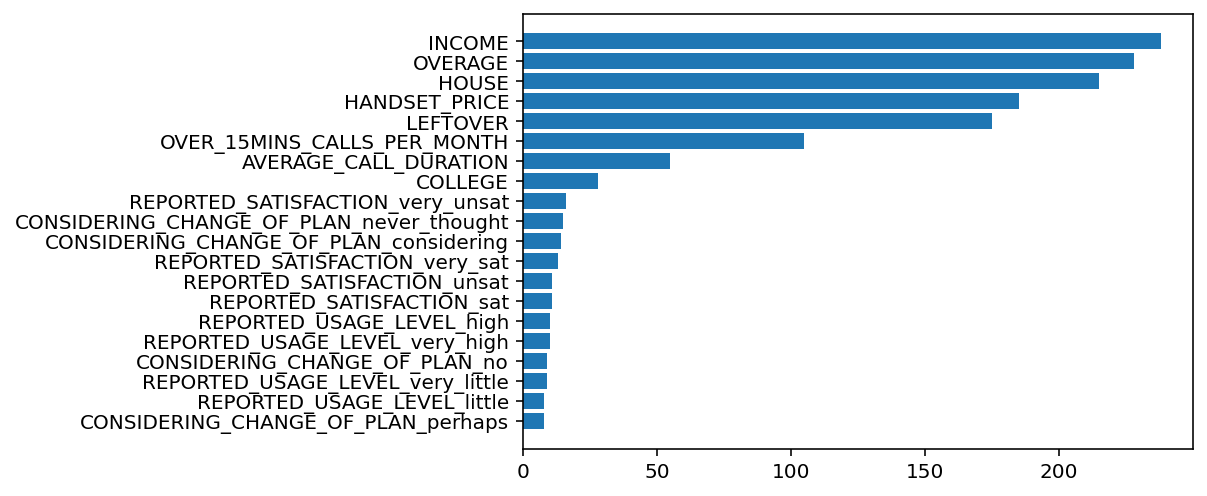

In [178]:
# 변수 중요도 시각화
df = pd.DataFrame()
df['feature'] = list(x)
df['importance'] = model.best_estimator_.feature_importances_
df.sort_values(by='importance', ascending=True, inplace=True)

plt.barh(y=df['feature'], width=df['importance'])
plt.show()

# 7.성능 평가

- 최적 파라미터로 학습된 모델에 대해 최종 성능 평가를 진행합니다.

In [179]:
# 예측하기
y_pred = model.predict(x_test)

In [180]:
# 성능평가
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[2481   66]
 [2381   72]]
              precision    recall  f1-score   support

           0       0.51      0.97      0.67      2547
           1       0.52      0.03      0.06      2453

    accuracy                           0.51      5000
   macro avg       0.52      0.50      0.36      5000
weighted avg       0.52      0.51      0.37      5000

